Results generation for my master's thesis. 

In includes more examples, since I compare methods created in the earlier stages of development. 

In [1]:
import os

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
from utils.datasets import DATASETS_INFO
from utils.plotting import set_legend, set_difficulty_legend, style_legend_titles_by_setting_position, show_xgb, set_labels, plot_low_depth, plot_hybrid
from utils.visualization_helpers import *

import ipywidgets as widgets
import pickle

%reload_ext autoreload
%autoreload 2

In [2]:
VARIANTS = [
    ("warm_best", "results/warmstart/base"),
    ("warm_1hour", "results/warmstart/1hour"),
    ("warm_nolim", "results/warmstart/nolim"),
    ("warm_0focus", "results/warmstart/def_focus"),
    ("warm_05heur", "results/warmstart/def_heur"),
    ("warm_d5", "results/warmstart/d5"),
    ("warm_d3", "results/warmstart/d3"),
    ("warm_50k", "results/warmstart/50k"),
    ("warm_soft", "results/warmstart/soft"),
         
    ("gradual", "results/gradual/base"),
    ("halving", "results/halving/base"),
    ("direct", "results/direct/base"),
    ("OCT", "results/OCT/no_warm"),
    ("OCT_warm", "results/OCT/base"),
]

DIFFICULTIES = ["EASY", "MEDIUM", "HARD"]

TREE_PATHS = {
    "depth20": "results/best_trees_unconstrained.pickle",
    "depth4": "results/best_trees_base.pickle",
    "depth3": "results/best_trees_d3.pickle",
}

jobs = {}
for name, res_path in VARIANTS:
    jobs[name] = pd.read_csv(os.path.join(res_path, "results.csv"))
    
os.makedirs("master_plots", exist_ok=True)

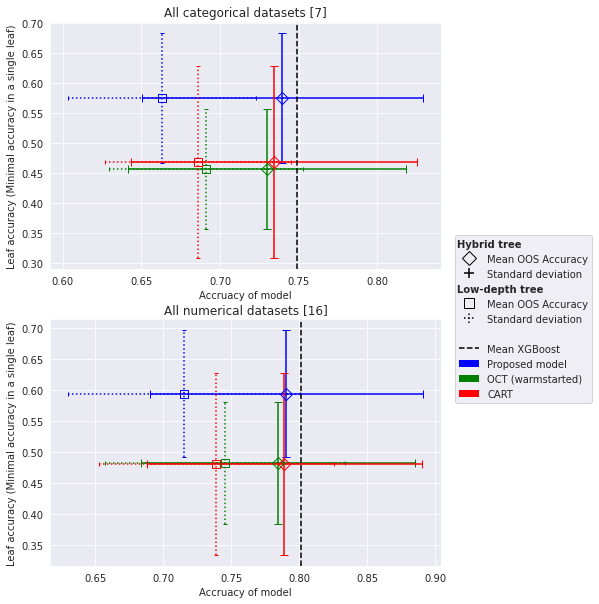

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(7,10))
i = 0
xgbvals = get_XGB_est_values()

values = {}
name = "warm_best"
values["Proposed model"] = {
    "base": get_values_categ(jobs, name, reduced=True),
    "extended": get_values_categ(jobs, name, extended=True)
}

name = "OCT_warm"
values["OCT (warmstarted)"] = {
    "base": get_values_categ(jobs, name, reduced=True),
    "extended": get_values_categ(jobs, name, extended=True)
}

values["CART"] = {
    "base": get_tree_results_categ(TREE_PATHS["depth4"]),
    "extended": get_tree_results_categ(TREE_PATHS["depth4"], extended=True)
}

for dtype in DATASETS_INFO:
    colors = ["b","g","r"]
    mode = "std"
    for c, n in zip(colors, values):
        vals = values[n]["base"][dtype]
        plot_low_depth(axes[i], vals["TestAcc"], vals["TestLeafAcc"], c)
        
        vals = values[n]["extended"][dtype]
        plot_hybrid(axes[i], vals["TestAcc"], vals["TestLeafAcc"], c)

    show_xgb(axes[i], xgbvals[dtype]["TestAcc"].mean())

    set_labels(axes[i], f"All {dtype} datasets [{len(DATASETS_INFO[dtype])}]")
    i += 1
set_legend(axes[1], values.keys(), colors, anchor=(1.4, 1))
        
plt.savefig("master_plots/agg_w_oct.pdf", bbox_inches='tight')

In [4]:
values = {}
for dtype in DATASETS_INFO:
    for dataset in DATASETS_INFO[dtype]:
        d_id = dtype[0]+"_"+dataset
        values[d_id] = {}
        values[d_id]["XGB"] = get_XGB_dataset_est_values()[dtype][dataset]["TestAcc"].mean()
        name = "warm_best"
        values[d_id]["Our leaf"] = get_values(jobs, name, reduced=True)[dtype][dataset]["TestLeafAcc"].mean()
        values[d_id]["Our total"] = get_values(jobs, name, extended=True)[dtype][dataset]["TestAcc"].mean()
        values[d_id]["CART leaf"] = get_tree_results(TREE_PATHS["depth4"])[dtype][dataset]["TestLeafAcc"].mean()
        values[d_id]["CART total"] = get_tree_results(TREE_PATHS["depth4"], extended=True)[dtype][dataset]["TestAcc"].mean()
        
df = pd.DataFrame(values).T
df["leaf_diff"] = df["Our leaf"] - df["CART leaf"]
print(df["leaf_diff"].mean())

df["tot_diff"] = df["Our total"] - df["CART total"]
print(df["tot_diff"].mean())

    

0.11163884465004084
0.002703625722874337


In [5]:
for dtype in DATASETS_INFO:
    values = {}
    for dataset in DATASETS_INFO[dtype]:
        d_id = dtype[0]+"_"+dataset
        values[d_id] = {}
        values[d_id]["XGB"] = get_XGB_dataset_est_values()[dtype][dataset]["TestAcc"].mean()
        name = "warm_best"
        values[d_id]["Our leaf"] = get_values(jobs, name, reduced=True)[dtype][dataset]["TestLeafAcc"].mean()
        values[d_id]["Our total"] = get_values(jobs, name, extended=True)[dtype][dataset]["TestAcc"].mean()
        values[d_id]["CART leaf"] = get_tree_results(TREE_PATHS["depth4"])[dtype][dataset]["TestLeafAcc"].mean()
        values[d_id]["CART total"] = get_tree_results(TREE_PATHS["depth4"], extended=True)[dtype][dataset]["TestAcc"].mean()
        
    df = pd.DataFrame(values).T
    df["leaf_diff"] = df["Our leaf"] - df["CART leaf"]
    print(dtype)
    # def print_for_table(series):
    #     print(f'{dtype} & {series.min()*100:.3f}\\% & {series.mean()*100:.3f} $\\pm${series.std()*100:.3f}\\% & {series.max()*100:.3f}\\%')
    def print_for_table(series):
        print(f'& {dtype} & ${series.min():.4f}$ & ${series.mean():.4f} \\pm{series.std():.4f}$ & ${series.max():.4f}$ \\\\')
        
    # print(f'Mean: {df["leaf_diff"].mean()*100:.3f}%, Std: {df["leaf_diff"].std()*100:.3f}%, Min:{df["leaf_diff"].min()*100:.3f}%, Max:{df["leaf_diff"].max()*100:.3f}%')
    # print(f'{dtype} & {df["leaf_diff"].min():.4f}\\% & {df["leaf_diff"].mean():.4f} $\\pm${df["leaf_diff"].std():.4f}\\% & {df["leaf_diff"].max():.4f}\\%')
    print_for_table(df["leaf_diff"])
    df["tot_diff"] = df["Our total"] - df["CART total"]
    # print(f'Mean: {df["tot_diff"].mean()*100:.3f}%, Std: {df["tot_diff"].std()*100:.3f}%, Min:{df["tot_diff"].min()*100:.3f}%, Max:{df["tot_diff"].max()*100:.3f}%')
    # print(f'{dtype} & {df["tot_diff"].min():.4f}\\% & {df["tot_diff"].mean():.4f} $\\pm${df["tot_diff"].std():.4f}\\% & {df["tot_diff"].max():.4f}\\%')
    print_for_table(df["tot_diff"])
    df["xgb_diff"] = df["Our total"] - df["XGB"]
    # print(f'Mean: {df["xgb_diff"].mean()*100:.3f}%, Std: {df["xgb_diff"].std()*100:.3f}%, Min:{df["xgb_diff"].min()*100:.3f}%, Max:{df["xgb_diff"].max()*100:.3f}%')
    # print(f'{dtype} & {df["xgb_diff"].min():.4f}\\% & {df["xgb_diff"].mean():.4f} $\\pm${df["xgb_diff"].std():.4f}\\% & {df["xgb_diff"].max():.4f}\\%')
    print_for_table(df["xgb_diff"])
    

categorical
& categorical & $-0.0247$ & $0.1064 \pm0.0729$ & $0.1905$ \\
& categorical & $-0.0027$ & $0.0053 \pm0.0084$ & $0.0182$ \\
& categorical & $-0.0228$ & $-0.0095 \pm0.0064$ & $-0.0036$ \\
numerical
& numerical & $-0.0553$ & $0.1139 \pm0.0630$ & $0.2116$ \\
& numerical & $-0.0253$ & $0.0016 \pm0.0086$ & $0.0111$ \\
& numerical & $-0.0276$ & $-0.0108 \pm0.0076$ & $0.0005$ \\


In [6]:
for dtype in DATASETS_INFO:
    values = {}
    for dataset in DATASETS_INFO[dtype]:
        d_id = dtype[0]+"_"+dataset
        values[d_id] = {}
        values[d_id]["XGB"] = get_XGB_dataset_est_values()[dtype][dataset]["TestAcc"].mean()
        name = "warm_50lim"
        values[d_id]["CART leaf"] = get_tree_results(TREE_PATHS["depth4"])[dtype][dataset]["TestLeafAcc"].mean()
        values[d_id]["CART total"] = get_tree_results(TREE_PATHS["depth4"], extended=True)[dtype][dataset]["TestAcc"].mean()
        values[d_id]["dCART leaf"] = get_tree_results(TREE_PATHS["depth20"])[dtype][dataset]["TestLeafAcc"].mean()
        values[d_id]["dCART total"] = get_tree_results(TREE_PATHS["depth20"], extended=True)[dtype][dataset]["TestAcc"].mean()
        
    df = pd.DataFrame(values).T
    df["leaf_diff"] = df["CART leaf"] - df["dCART leaf"]
    print(dtype)
    def print_for_table(series):
        print(f'& {dtype} & ${series.min():.4f}$ & ${series.mean():.4f} \\pm{series.std():.4f}$ & ${series.max():.4f}$ \\\\')
        
    print_for_table(df["leaf_diff"])
    df["tot_diff"] = df["CART total"] - df["dCART total"]
    print_for_table(df["tot_diff"])
    # df["xgb_diff"] = df["Our total"] - df["XGB"]
    # print_for_table(df["xgb_diff"])
    

categorical
& categorical & $-0.0769$ & $0.2053 \pm0.2389$ & $0.5404$ \\
& categorical & $-0.0025$ & $0.0173 \pm0.0185$ & $0.0420$ \\
numerical
& numerical & $-0.1183$ & $0.2441 \pm0.2115$ & $0.5680$ \\
& numerical & $-0.0006$ & $0.0156 \pm0.0119$ & $0.0370$ \\


In [7]:
jobs["warm_best"][jobs["warm_best"]["JobName"] == "Whh_8_n_pol"][["JobName","ReducedTestLeafAcc","TestAcc","ExtendedTestAcc","StartReducedTrainLeafAcc","StartReducedTestLeafAcc","StartTestAcc"]]


,JobName,ReducedTestLeafAcc,TestAcc,ExtendedTestAcc,StartReducedTrainLeafAcc,StartReducedTestLeafAcc,StartTestAcc
206,Whh_8_n_pol,0.865065,0.893902,0.976202,0.684444,0.571429,0.921666


In [8]:
res = get_tree_results(TREE_PATHS["depth4"])["numerical"]["pol"]
print("Train Leaf Acc:", res["TrainLeafAcc"][8])
print("Test Leaf Acc:", res["TestLeafAcc"][8])
print("Test Acc:", res["TestAcc"][8])
print("Extended Test acc:", get_tree_results(TREE_PATHS["depth4"], extended=True)["numerical"]["pol"]["TestAcc"][8])


Train Leaf Acc: 0.6844444444444444
Test Leaf Acc: 0.5714285714285714
Test Acc: 0.9216658403569657
Extended Test acc: 0.9747149231531979


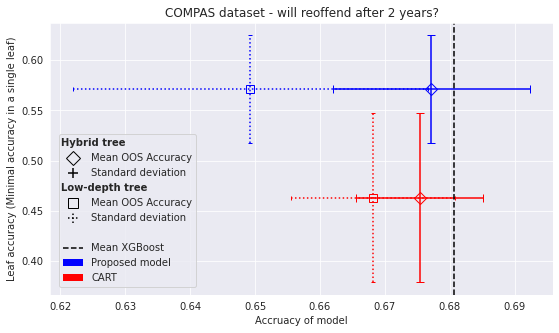

In [9]:
fig, axes = plt.subplots(1, figsize=(9,5))
i = 0
xgbvals = get_XGB_dataset_est_values()

dtype = "categorical"
dname = "compas-two-years"

values = {}
name = "warm_best"
values["Proposed model"] = {
    "base": get_values(jobs, name, reduced=True)[dtype][dname],
    "extended": get_values(jobs, name, extended=True)[dtype][dname]
}
values["CART"] = {
    "base": get_tree_results(TREE_PATHS["depth4"])[dtype][dname],
    "extended": get_tree_results(TREE_PATHS["depth4"], extended=True)[dtype][dname]
}

colors = ["b","r"]
for c, n in zip(colors, values):
    vals = values[n]["base"]
    plot_low_depth(axes, vals["TestAcc"], vals["TestLeafAcc"], c)

    vals = values[n]["extended"]
    plot_hybrid(axes, vals["TestAcc"], vals["TestLeafAcc"], c)

show_xgb(axes, xgbvals[dtype][dname]["TestAcc"].mean())

set_labels(axes, "COMPAS dataset - will reoffend after 2 years?")
set_legend(axes, values.keys(), colors, anchor=(0.3, 0.31))
i += 1
        
plt.savefig("master_plots/motivation.pdf", bbox_inches='tight')

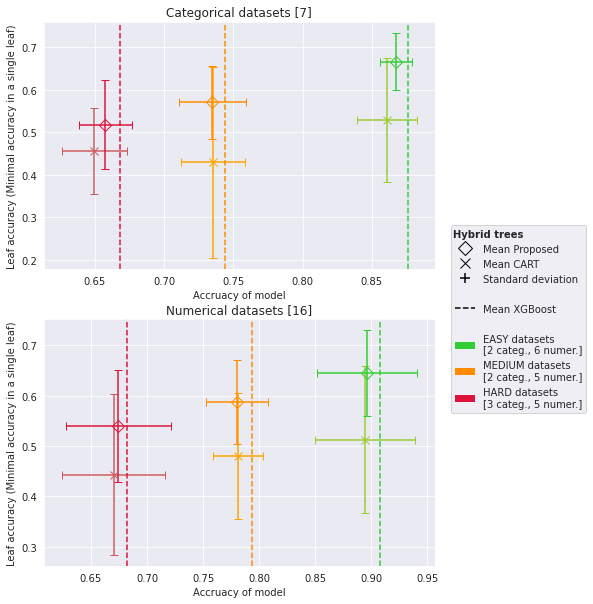

In [10]:
name = "warm_best"
values = gather_by_difficulty(get_values(jobs, name, extended=True))
tree_values = gather_by_difficulty(get_tree_results(TREE_PATHS["depth4"], extended=True))
xgb_vals = gather_by_difficulty(get_XGB_dataset_est_values()) 
mode = "std"

fig, axes = plt.subplots(2, 1, figsize=(7,10))
for i, dataset_type in enumerate(DATASETS_INFO):
    colors = ["limegreen", "darkorange", "crimson"]
    # a little better colors
    l_cols = {"limegreen":"yellowgreen", "darkorange":"orange", "crimson":"indianred"}
    for c, difficulty in zip(colors, DIFFICULTIES):
        vals = tree_values[dataset_type][difficulty]["TestAcc"]
        leaf_vals = tree_values[dataset_type][difficulty]["TestLeafAcc"]
        axes[i].errorbar([vals.mean()], [leaf_vals.mean()],
            xerr=vals.std(), yerr=leaf_vals.std(), capsize=4, 
            label=f"{name} - test", marker="x", markersize=8,
            markerfacecolor=(1,1,1,0), markeredgecolor=l_cols[c], color=l_cols[c])
        
        vals = values[dataset_type][difficulty]["TestAcc"]
        leaf_vals = values[dataset_type][difficulty]["TestLeafAcc"]
        axes[i].errorbar([vals.mean()], [leaf_vals.mean()],
            xerr=vals.std(), yerr=leaf_vals.std(), capsize=4, 
            label=f"{name} - test", marker="D", markersize=8,
            markerfacecolor=(1,1,1,0), markeredgecolor=c, color=c)
    
    for c, difficulty in zip(colors, DIFFICULTIES):
        show_xgb(axes[i], xgb_vals[dataset_type][difficulty]["TestAcc"].mean(), color=c)
    
    set_labels(axes[i], f"{'Numerical' if dataset_type[0] == 'n' else 'Categorical'} datasets [{len(DATASETS_INFO[dataset_type])}]")


names = [
    f"{d} datasets\n[{len(values['categorical'][d]['TrainAcc'])//10} categ., {len(values['numerical'][d]['TrainAcc'])//10} numer.]" for d in DIFFICULTIES
]

set_difficulty_legend(axes[1], names, colors, anchor=(1.4, 1))


plt.savefig("master_plots/difficulty.pdf", bbox_inches='tight')

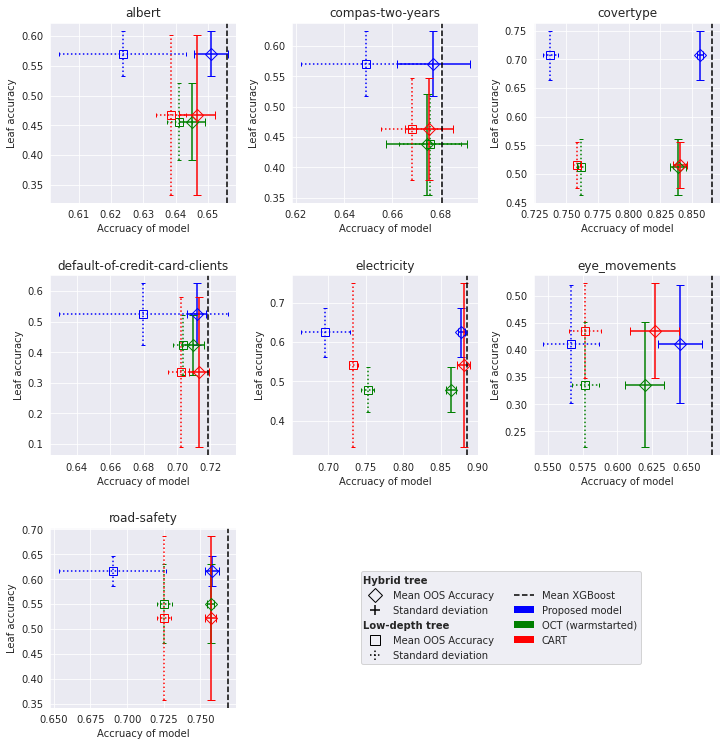

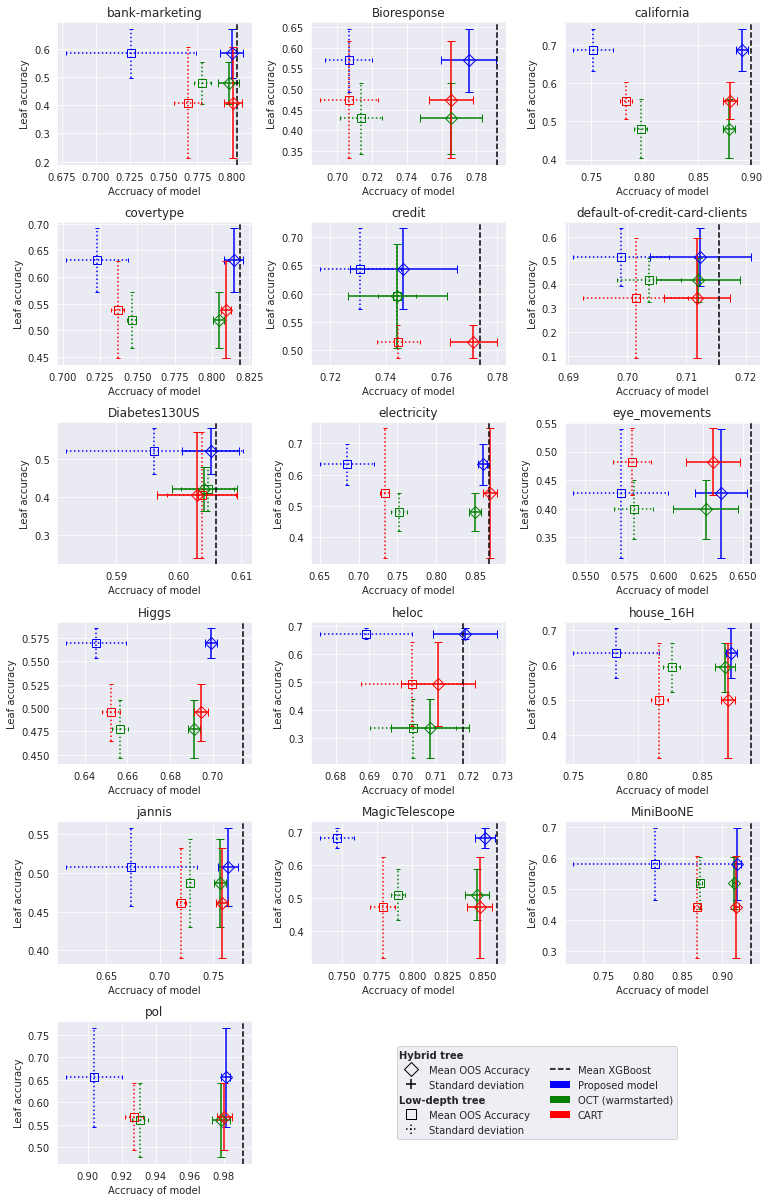

In [11]:
xgbvals = get_XGB_dataset_est_values()

values = {}
name = "warm_best"
values["Proposed model"] = {
    "base": get_values(jobs, name, reduced=True),
    "extended": get_values(jobs, name, extended=True)
}

name = "OCT_warm"
values["OCT (warmstarted)"] = {
    "base": get_values(jobs, name, reduced=True),
    "extended": get_values(jobs, name, extended=True)
}

values["CART"] = {
    "base": get_tree_results(TREE_PATHS["depth4"]),
    "extended": get_tree_results(TREE_PATHS["depth4"], extended=True)
}

colors = ["b","g","r"]
for dtype in DATASETS_INFO:
    rows, cols = int(np.ceil(len(DATASETS_INFO[dtype])/3)), 3
    figsize = (cols*4,rows*4.2) if dtype[0] == "c" else (cols*4.2,rows*3.5)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    i = 0
    for dataset in DATASETS_INFO[dtype]:
        for c, n in zip(colors, values):
            vals = values[n]["base"][dtype][dataset]
            plot_low_depth(axes[i//cols, i%cols], vals["TestAcc"], vals["TestLeafAcc"], c)

            vals = values[n]["extended"][dtype][dataset]
            plot_hybrid(axes[i//cols, i%cols], vals["TestAcc"], vals["TestLeafAcc"], c)    

        show_xgb(axes[i//cols, i%cols], xgbvals[dtype][dataset]["TestAcc"])
        set_labels(axes[i//cols, i%cols], dataset, ylabel="Leaf accuracy")
        i += 1
    set_legend(axes[i//cols, (i-1)%cols], values.keys(), colors, anchor=(3.2, 0.5), ncol=2)
    for j in range(i, cols*rows):
        fig.delaxes(axes[j//cols, j%cols])

    # plt.show()
    plt.savefig(f"master_plots/details_{dtype}.pdf", bbox_inches='tight')

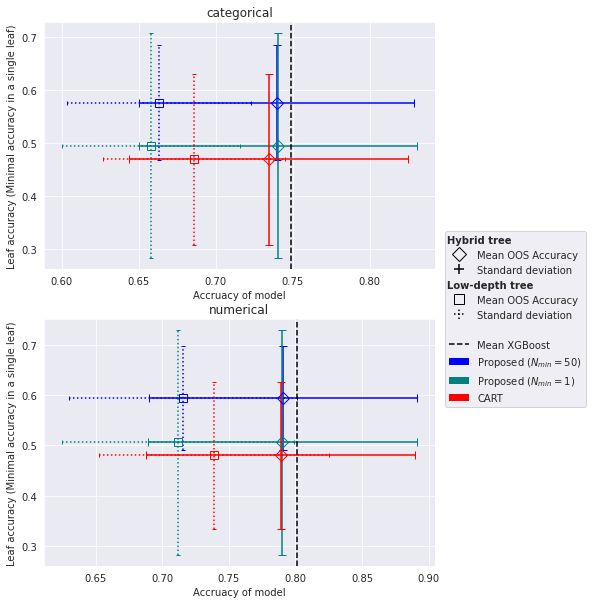

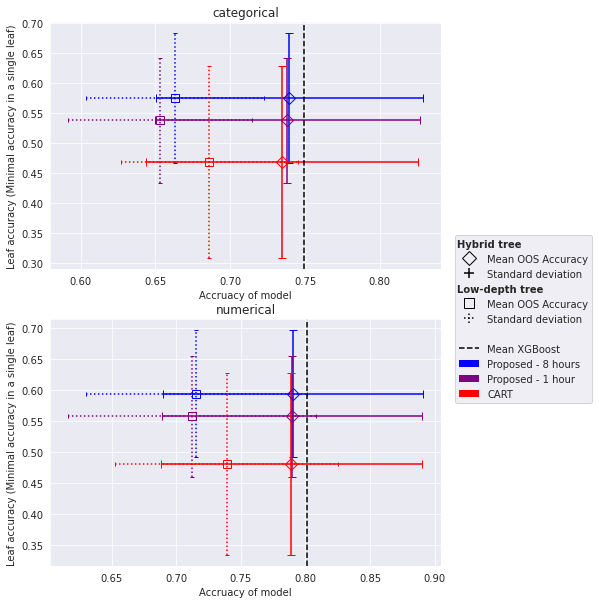

In [12]:
xgbvals = get_XGB_est_values()


attrs = {
    "warm_nolim": {"color":"teal", "name":"Proposed ($N_{min}=1$)", "appendage":"($N_{min}=50$)"},
    "warm_1hour": {"color":"purple", "name":"Proposed - 1 hour", "appendage":"- 8 hours"},
    # "warm_d5": {"color":"grey", "name":"Proposed (depth = 5)", "appendage":"(depth = 4)"},
}
for model in attrs:
    fig, axes = plt.subplots(2, 1, figsize=(7,10))
    i = 0
    values = {}
    for name, modelname in [("Proposed " + attrs[model]["appendage"], "warm_best"), (attrs[model]["name"], model)]:
        values[name] = {
            "base": get_values_categ(jobs, modelname, reduced=True),
            "extended": get_values_categ(jobs, modelname, extended=True)
        }

    values["CART" + (' (depth = 4)' if "d5" in model else '')] = {
        "base": get_tree_results_categ(TREE_PATHS["depth4"]),
        "extended": get_tree_results_categ(TREE_PATHS["depth4"], extended=True)
    }

    for dtype in DATASETS_INFO:
        colors = ["b", attrs[model]["color"], "r"]
        for c, n in zip(colors, values):
            vals = values[n]["base"][dtype]
            plot_low_depth(axes[i%2], vals["TestAcc"], vals["TestLeafAcc"], c)

            vals = values[n]["extended"][dtype]
            plot_hybrid(axes[i%2], vals["TestAcc"], vals["TestLeafAcc"], c)

        show_xgb(axes[i%2], xgbvals[dtype]["TestAcc"].mean())
        set_labels(axes[i%2], dtype)
        i += 1
    set_legend(axes[1], values.keys(), colors, anchor=(1.4, 1))
    
    # plt.show()
    plt.savefig(f"master_plots/compare_{model}.pdf", bbox_inches='tight')

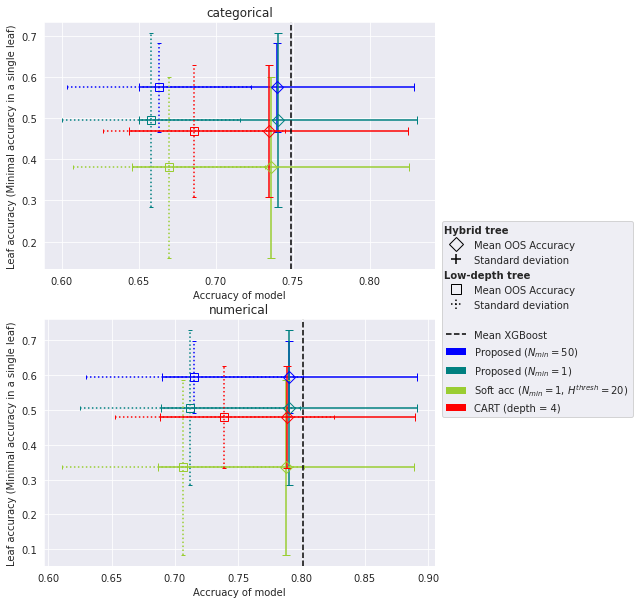

In [13]:
xgbvals = get_XGB_est_values()


fig, axes = plt.subplots(2, 1, figsize=(7,10))
i = 0
values = {}
for name, modelname in [
        ("Proposed ($N_{min}=50$)", "warm_best"), 
        ("Proposed ($N_{min}=1$)", "warm_nolim"), 
        ("Soft acc ($N_{min}=1$, $H^{thresh} = 20$)", "warm_soft"), 
    ]:
    values[name] = {
        "base": get_values_categ(jobs, modelname, reduced=True),
        "extended": get_values_categ(jobs, modelname, extended=True)
    }

values["CART (depth = 4)"] = {
    "base": get_tree_results_categ(TREE_PATHS["depth4"]),
    "extended": get_tree_results_categ(TREE_PATHS["depth4"], extended=True)
}

for dtype in DATASETS_INFO:
    colors = ["b", "teal", "yellowgreen", "r"]
    for c, n in zip(colors, values):
        vals = values[n]["base"][dtype]
        plot_low_depth(axes[i%2], vals["TestAcc"], vals["TestLeafAcc"], c)

        vals = values[n]["extended"][dtype]
        plot_hybrid(axes[i%2], vals["TestAcc"], vals["TestLeafAcc"], c)

    show_xgb(axes[i%2], xgbvals[dtype]["TestAcc"].mean())
    set_labels(axes[i%2], dtype)
    i += 1
set_legend(axes[1], values.keys(), colors, anchor=(1.52, 1))
# set_legend(axes[1], values.keys(), colors, anchor=(1.35, 1))

# plt.show()
plt.savefig(f"master_plots/compare_soft.pdf", bbox_inches='tight')

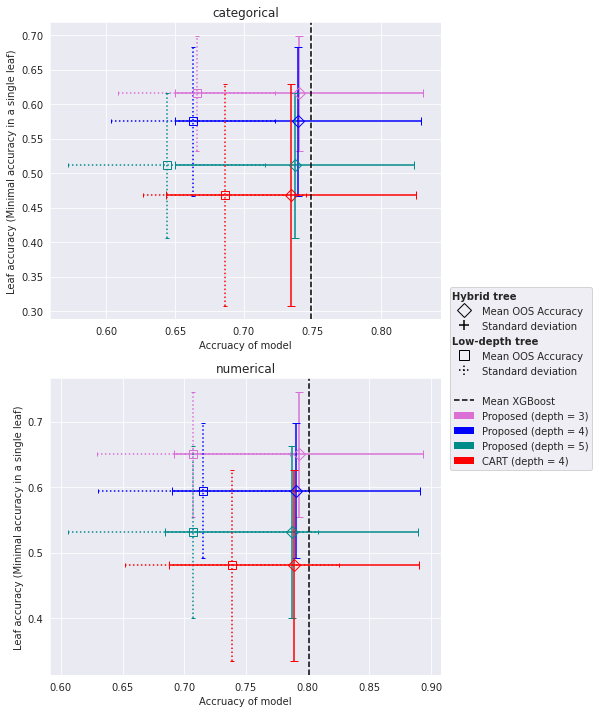

In [14]:
xgbvals = get_XGB_est_values()


fig, axes = plt.subplots(2, 1, figsize=(7,12))
i = 0
values = {}
for name, modelname in [
        ("Proposed (depth = 3)", "warm_d3"), 
        ("Proposed (depth = 4)", "warm_best"), 
        ("Proposed (depth = 5)", "warm_d5"), 
    ]:
    values[name] = {
        "base": get_values_categ(jobs, modelname, reduced=True),
        "extended": get_values_categ(jobs, modelname, extended=True)
    }

values["CART (depth = 4)"] = {
    "base": get_tree_results_categ(TREE_PATHS["depth4"]),
    "extended": get_tree_results_categ(TREE_PATHS["depth4"], extended=True)
}
# values["CART (depth = 3)"] = {
#     "base": get_tree_results_categ(TREE_PATHS["depth3"]),
#     "extended": get_tree_results_categ(TREE_PATHS["depth3"], extended=True)
# }


for dtype in DATASETS_INFO:
    colors = ["orchid", "b", "darkcyan", "r", "peru"]
    for c, n in zip(colors, values):
        vals = values[n]["base"][dtype]
        plot_low_depth(axes[i%2], vals["TestAcc"], vals["TestLeafAcc"], c)

        vals = values[n]["extended"][dtype]
        plot_hybrid(axes[i%2], vals["TestAcc"], vals["TestLeafAcc"], c)

    show_xgb(axes[i%2], xgbvals[dtype]["TestAcc"].mean())
    set_labels(axes[i%2], dtype)
    i += 1
set_legend(axes[1], values.keys(), colors, anchor=(1.4, 1))
# set_legend(axes[1], values.keys(), colors, anchor=(1.35, 1))

# plt.show()
plt.savefig(f"master_plots/compare_depth.pdf", bbox_inches='tight')

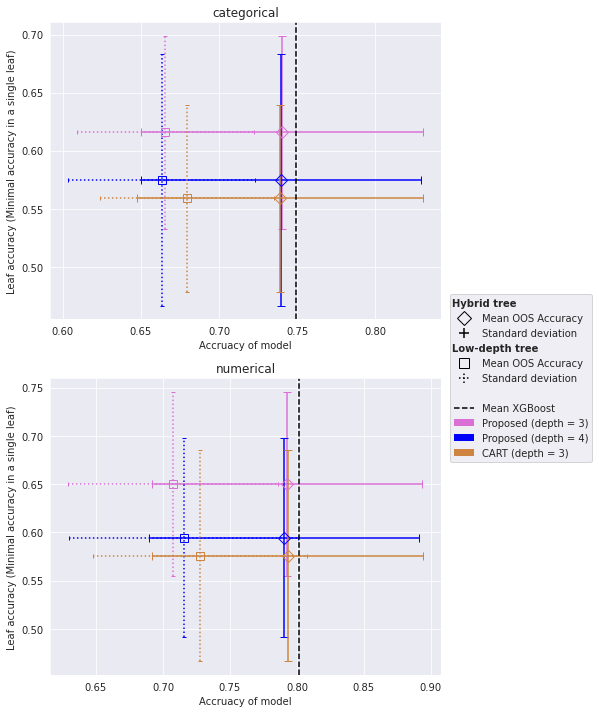

In [15]:
xgbvals = get_XGB_est_values()



fig, axes = plt.subplots(2, 1, figsize=(7,12))
i = 0
values = {}
for name, modelname in [
        ("Proposed (depth = 3)", "warm_d3"), 
        ("Proposed (depth = 4)", "warm_best"), 
        # ("Proposed (depth = 5)", "warm_d5"), 
    ]:
    values[name] = {
        "base": get_values_categ(jobs, modelname, reduced=True),
        "extended": get_values_categ(jobs, modelname, extended=True)
    }

# values["CART (depth = 4)"] = {
#     "base": get_tree_results_categ(TREE_PATHS["depth4"]),
#     "extended": get_tree_results_categ(TREE_PATHS["depth4"], extended=True)
# }
values["CART (depth = 3)"] = {
    "base": get_tree_results_categ(TREE_PATHS["depth3"]),
    "extended": get_tree_results_categ(TREE_PATHS["depth3"], extended=True)
}

for dtype in DATASETS_INFO:
    colors = ["orchid", "b", "peru"]
    for c, n in zip(colors, values):
        vals = values[n]["base"][dtype]
        plot_low_depth(axes[i%2], vals["TestAcc"], vals["TestLeafAcc"], c)

        vals = values[n]["extended"][dtype]
        plot_hybrid(axes[i%2], vals["TestAcc"], vals["TestLeafAcc"], c)

    show_xgb(axes[i%2], xgbvals[dtype]["TestAcc"].mean())
    set_labels(axes[i%2], dtype)
    i += 1
set_legend(axes[1], values.keys(), colors, anchor=(1.4, 1))

plt.savefig(f"master_plots/compare_depth3.pdf", bbox_inches='tight')

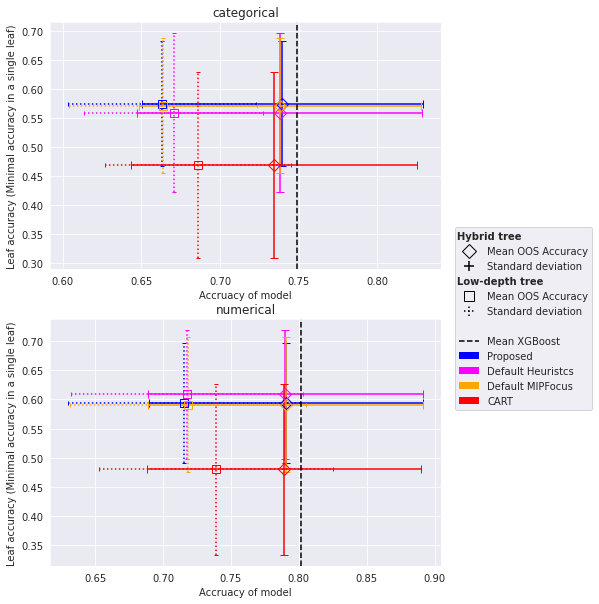

In [16]:
xgbvals = get_XGB_est_values()


fig, axes = plt.subplots(2, 1, figsize=(7, 10))
i = 0
values = {}
for name, modelname in [
        ("Proposed", "warm_best"), 
        ("Default Heuristcs", "warm_05heur"), 
        ("Default MIPFocus", "warm_0focus"), 
    ]:
    values[name] = {
        "base": get_values_categ(jobs, modelname, reduced=True),
        "extended": get_values_categ(jobs, modelname, extended=True)
    }

values["CART"] = {
    "base": get_tree_results_categ(TREE_PATHS["depth4"]),
    "extended": get_tree_results_categ(TREE_PATHS["depth4"], extended=True)
}

for dtype in DATASETS_INFO:
    colors = ["b", "magenta", "orange", "r"]
    for c, n in zip(colors, values):
        vals = values[n]["base"][dtype]
        plot_low_depth(axes[i%2], vals["TestAcc"], vals["TestLeafAcc"], c)

        vals = values[n]["extended"][dtype]
        plot_hybrid(axes[i%2], vals["TestAcc"], vals["TestLeafAcc"], c)

    show_xgb(axes[i%2], xgbvals[dtype]["TestAcc"].mean())
    set_labels(axes[i%2], dtype)
    i += 1
set_legend(axes[1], values.keys(), colors, anchor=(1.4, 1))
# set_legend(axes[1], values.keys(), colors, anchor=(1.35, 1))

# plt.show()
plt.savefig(f"master_plots/compare_MIP.pdf", bbox_inches='tight')

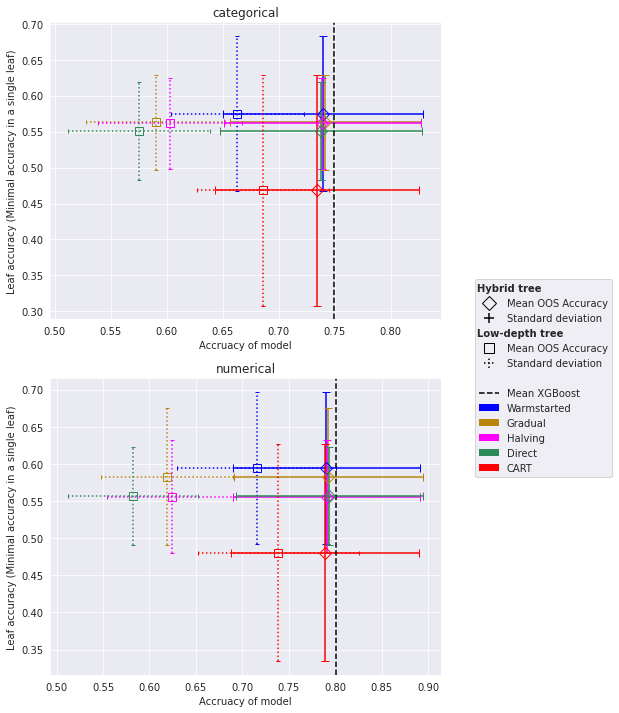

In [17]:
xgbvals = get_XGB_est_values()


fig, axes = plt.subplots(2, 1, figsize=(7,12))
i = 0
values = {}
for name, modelname in [
        ("Warmstarted", "warm_best"), 
        ("Gradual", "gradual"), 
        ("Halving", "halving"), 
        ("Direct", "direct"), 
    ]:
    values[name] = {
        "base": get_values_categ(jobs, modelname, reduced=True),
        "extended": get_values_categ(jobs, modelname, extended=True)
    }

values["CART"] = {
    "base": get_tree_results_categ(TREE_PATHS["depth4"]),
    "extended": get_tree_results_categ(TREE_PATHS["depth4"], extended=True)
}

for dtype in DATASETS_INFO:
    colors = ["b", "darkgoldenrod", "fuchsia", "seagreen", "r"]
    for c, n in zip(colors, values):
        vals = values[n]["base"][dtype]
        plot_low_depth(axes[i%2], vals["TestAcc"], vals["TestLeafAcc"], c)

        vals = values[n]["extended"][dtype]
        plot_hybrid(axes[i%2], vals["TestAcc"], vals["TestLeafAcc"], c)

    show_xgb(axes[i%2], xgbvals[dtype]["TestAcc"].mean())
    set_labels(axes[i%2], dtype)
    i += 1
set_legend(axes[1], values.keys(), colors, anchor=(1.45, 1))

# plt.show()
plt.savefig(f"master_plots/compare_approaches.pdf", bbox_inches='tight')

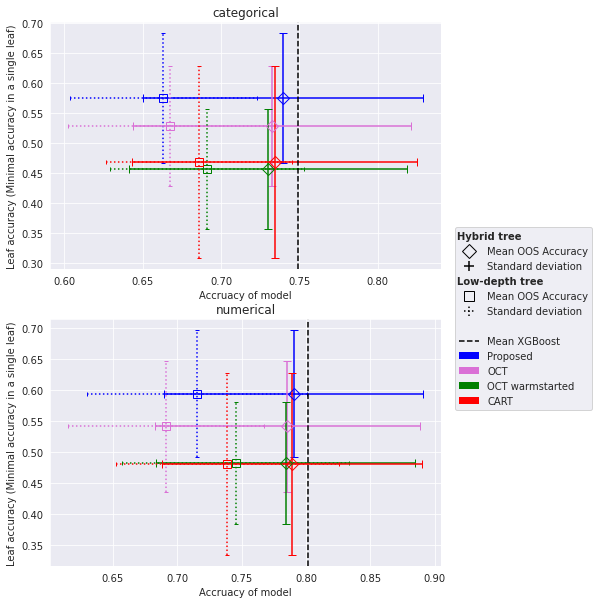

In [18]:
xgbvals = get_XGB_est_values()


fig, axes = plt.subplots(2, 1, figsize=(7,10))
i = 0
values = {}
for name, modelname in [
        ("Proposed", "warm_best"), 
        ("OCT", "OCT"), 
        ("OCT warmstarted", "OCT_warm"), 
    ]:
    values[name] = {
        "base": get_values_categ(jobs, modelname, reduced=True),
        "extended": get_values_categ(jobs, modelname, extended=True)
    }

values["CART"] = {
    "base": get_tree_results_categ(TREE_PATHS["depth4"]),
    "extended": get_tree_results_categ(TREE_PATHS["depth4"], extended=True)
}

for dtype in DATASETS_INFO:
    colors = ["b", "orchid", "g", "r"]
    for c, n in zip(colors, values):
        vals = values[n]["base"][dtype]
        plot_low_depth(axes[i%2], vals["TestAcc"], vals["TestLeafAcc"], c)

        vals = values[n]["extended"][dtype]
        plot_hybrid(axes[i%2], vals["TestAcc"], vals["TestLeafAcc"], c)

    show_xgb(axes[i%2], xgbvals[dtype]["TestAcc"].mean())
    set_labels(axes[i%2], dtype)
    i += 1
set_legend(axes[1], values.keys(), colors, anchor=(1.4, 1))

# plt.show()
plt.savefig(f"master_plots/compare_OCT.pdf", bbox_inches='tight')

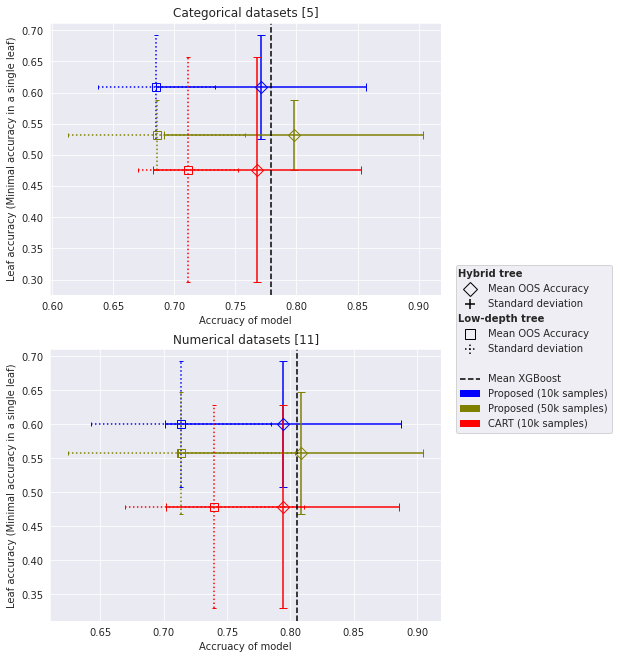

In [19]:
xgbvals = get_XGB_dataset_est_values()


fig, axes = plt.subplots(2, 1, figsize=(7,11))
i = 0
values = {}
for name, modelname in [("Proposed (10k samples)", "warm_best"), 
                        ("Proposed (50k samples)", "warm_50k")]:
    values[name] = {
        "base": get_values(jobs, modelname, reduced=True),
        "extended": get_values(jobs, modelname, extended=True)
    }

values["CART (10k samples)"] = {
    "base": get_tree_results(TREE_PATHS["depth4"]),
    "extended": get_tree_results(TREE_PATHS["depth4"], extended=True)
}

for dtype in DATASETS_INFO:
    colors = ["b", "olive", "r"]
    for c, n in zip(colors, values):
        b_vals_m = [] 
        b_vals_l = [] 
        e_vals_m = [] 
        e_vals_l = [] 
        n_datasets = 0
        for dataset in DATASETS_INFO[dtype]:
            if DATASETS_INFO[dtype][dataset]["n_points"] > 10000/0.8:
                # if c == "olive":
                #     print(dataset, values[n]["extended"][dtype][dataset])
                b_vals_m += list(values[n]["base"][dtype][dataset]["TestAcc"])
                b_vals_l += list(values[n]["base"][dtype][dataset]["TestLeafAcc"])
                e_vals_m += list(values[n]["extended"][dtype][dataset]["TestAcc"])
                e_vals_l += list(values[n]["extended"][dtype][dataset]["TestLeafAcc"])
                n_datasets += 1
        # print(len(b_vals_m))
        # print(e_vals_m)
        plot_low_depth(axes[i%2], np.array(b_vals_m), np.array(b_vals_l), c)

        plot_hybrid(axes[i%2], np.array(e_vals_m), np.array(e_vals_l), c)

    xgb = []
    for dataset in DATASETS_INFO[dtype]:
        if DATASETS_INFO[dtype][dataset]["n_points"] > 10000/0.8:
            xgb += list(xgbvals[dtype][dataset]["TestAcc"])
    show_xgb(axes[i%2], sum(xgb)/len(xgb))
    set_labels(axes[i%2], f"{dtype[0].upper()}{dtype[1:]} datasets [{n_datasets}]")
    i += 1
set_legend(axes[1], values.keys(), colors, anchor=(1.45, 1))

# plt.show()
plt.savefig(f"master_plots/compare_50k.pdf", bbox_inches='tight')

In [20]:
for dtype in DATASETS_INFO:
    values = {}
    for dataset in DATASETS_INFO[dtype]:
        d_id = dtype[0]+"_"+dataset
        values[d_id] = {}
        values[d_id]["XGB"] = get_XGB_dataset_est_values()[dtype][dataset]["TestAcc"].mean()
        name = "warm_best"
        values[d_id]["Our leaf"] = get_values(jobs, name, reduced=True)[dtype][dataset]["TestLeafAcc"].mean()
        values[d_id]["Our total"] = get_values(jobs, name, extended=True)[dtype][dataset]["TestAcc"].mean()
        name = "warm_05heur"
        values[d_id]["heur leaf"] = get_values(jobs, name, reduced=True)[dtype][dataset]["TestLeafAcc"].mean()
        values[d_id]["heur total"] = get_values(jobs, name, extended=True)[dtype][dataset]["TestAcc"].mean()
        
    df = pd.DataFrame(values).T
    df["leaf_diff"] = df["Our leaf"] - df["heur leaf"]
    print(dtype)
    def print_for_table(series):
        print(f'& {dtype} & ${series.min():.4f}$ & ${series.mean():.4f} \\pm{series.std():.4f}$ & ${series.max():.4f}$ \\\\')
        
    print_for_table(df["leaf_diff"])
    df["tot_diff"] = df["Our total"] - df["heur total"]
    print_for_table(df["tot_diff"])
    # df["xgb_diff"] = df["Our total"] - df["XGB"]
    # print_for_table(df["xgb_diff"])



categorical
& categorical & $-0.0117$ & $0.0158 \pm0.0234$ & $0.0531$ \\
& categorical & $-0.0011$ & $0.0017 \pm0.0035$ & $0.0094$ \\
numerical
& numerical & $-0.1178$ & $-0.0143 \pm0.0402$ & $0.0435$ \\
& numerical & $-0.0047$ & $0.0005 \pm0.0025$ & $0.0062$ \\


In [21]:
for dtype in DATASETS_INFO:
    values = {}
    for dataset in DATASETS_INFO[dtype]:
        d_id = dtype[0]+"_"+dataset
        values[d_id] = {}
        values[d_id]["XGB"] = get_XGB_dataset_est_values()[dtype][dataset]["TestAcc"].mean()
        name = "warm_best"
        values[d_id]["Our leaf"] = get_values(jobs, name, reduced=True)[dtype][dataset]["TestLeafAcc"].mean()
        values[d_id]["Our total"] = get_values(jobs, name, extended=True)[dtype][dataset]["TestAcc"].mean()
        name = "warm_0focus"
        values[d_id]["focus leaf"] = get_values(jobs, name, reduced=True)[dtype][dataset]["TestLeafAcc"].mean()
        values[d_id]["focus total"] = get_values(jobs, name, extended=True)[dtype][dataset]["TestAcc"].mean()
        
    df = pd.DataFrame(values).T
    df["leaf_diff"] = df["Our leaf"] - df["focus leaf"]
    print(dtype)
    def print_for_table(series):
        print(f'& {dtype} & ${series.min():.4f}$ & ${series.mean():.4f} \\pm{series.std():.4f}$ & ${series.max():.4f}$ \\\\')
        
    print_for_table(df["leaf_diff"])
    df["tot_diff"] = df["Our total"] - df["focus total"]
    print_for_table(df["tot_diff"])
    # df["xgb_diff"] = df["Our total"] - df["XGB"]
    # print_for_table(df["xgb_diff"])



categorical
& categorical & $-0.0304$ & $0.0036 \pm0.0213$ & $0.0299$ \\
& categorical & $-0.0028$ & $0.0016 \pm0.0043$ & $0.0088$ \\
numerical
& numerical & $-0.0528$ & $0.0034 \pm0.0342$ & $0.0788$ \\
& numerical & $-0.0026$ & $0.0001 \pm0.0019$ & $0.0032$ \\


In [22]:
for dtype in DATASETS_INFO:
    values = {}
    for dataset in DATASETS_INFO[dtype]:
        d_id = dtype[0]+"_"+dataset
        values[d_id] = {}
        values[d_id]["XGB"] = get_XGB_dataset_est_values()[dtype][dataset]["TestAcc"].mean()
        name = "warm_best"
        values[d_id]["Our leaf"] = get_values(jobs, name, reduced=True)[dtype][dataset]["TestLeafAcc"].mean()
        values[d_id]["Our total"] = get_values(jobs, name, extended=True)[dtype][dataset]["TestAcc"].mean()
        name = "gradual"
        values[d_id]["gradual leaf"] = get_values(jobs, name, reduced=True)[dtype][dataset]["TestLeafAcc"].mean()
        values[d_id]["gradual total"] = get_values(jobs, name, extended=True)[dtype][dataset]["TestAcc"].mean()
        
    df = pd.DataFrame(values).T
    df["leaf_diff"] = df["Our leaf"] - df["gradual leaf"]
    print(dtype)
    def print_for_table(series):
        print(f'& {dtype} & ${series.min():.4f}$ & ${series.mean():.4f} \\pm{series.std():.4f}$ & ${series.max():.4f}$ \\\\')
        
    print_for_table(df["leaf_diff"])
    df["tot_diff"] = df["Our total"] - df["gradual total"]
    print_for_table(df["tot_diff"])
    # df["xgb_diff"] = df["Our total"] - df["XGB"]
    # print_for_table(df["xgb_diff"])



categorical
& categorical & $-0.1094$ & $0.0122 \pm0.0753$ & $0.1130$ \\
& categorical & $-0.0219$ & $-0.0021 \pm0.0094$ & $0.0083$ \\
numerical
& numerical & $-0.0867$ & $0.0117 \pm0.0624$ & $0.1154$ \\
& numerical & $-0.0103$ & $-0.0023 \pm0.0056$ & $0.0076$ \\


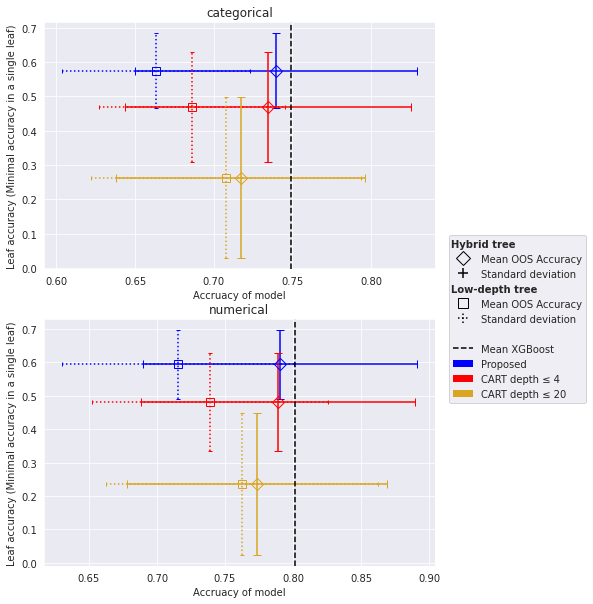

In [23]:
xgbvals = get_XGB_est_values()


fig, axes = plt.subplots(2, 1, figsize=(7,10))
i = 0
values = {}
for name, modelname in [
        ("Proposed", "warm_best"), 
    ]:
    values[name] = {
        "base": get_values_categ(jobs, modelname, reduced=True),
        "extended": get_values_categ(jobs, modelname, extended=True)
    }

values["CART depth ≤ 4"] = {
    "base": get_tree_results_categ(TREE_PATHS["depth4"]),
    "extended": get_tree_results_categ(TREE_PATHS["depth4"], extended=True)
}
values["CART depth ≤ 20"] = {
    "base": get_tree_results_categ(TREE_PATHS["depth20"]),
    "extended": get_tree_results_categ(TREE_PATHS["depth20"], extended=True)
}

for dtype in DATASETS_INFO:
    colors = ["b", "r", "goldenrod"]
    for c, n in zip(colors, values):
        vals = values[n]["base"][dtype]
        plot_low_depth(axes[i%2], vals["TestAcc"], vals["TestLeafAcc"], c)

        vals = values[n]["extended"][dtype]
        plot_hybrid(axes[i%2], vals["TestAcc"], vals["TestLeafAcc"], c)

    show_xgb(axes[i%2], xgbvals[dtype]["TestAcc"].mean())
    set_labels(axes[i%2], dtype)
    i += 1
set_legend(axes[1], values.keys(), colors, anchor=(1.4, 1))

# plt.show()
plt.savefig(f"master_plots/compare_CARTs.pdf", bbox_inches='tight')

In [24]:
stats8h = {}
for _, job in jobs["warm_best"].iterrows():
    logpath = job["Path"][:-3] + "log"
    stats8h["_".join(job["JobName"].split('_')[1:])] = get_MIP_process(logpath)
    
stats0f = {}
for _, job in jobs["warm_0focus"].iterrows():
    logpath = job["Path"][:-3] + "log"
    stats0f["_".join(job["JobName"].split('_')[1:])] = get_MIP_process(logpath)
    
stats05h = {}
for _, job in jobs["warm_05heur"].iterrows():
    logpath = job["Path"][:-3] + "log"
    stats05h["_".join(job["JobName"].split('_')[1:])] = get_MIP_process(logpath)
# print(stats0f)

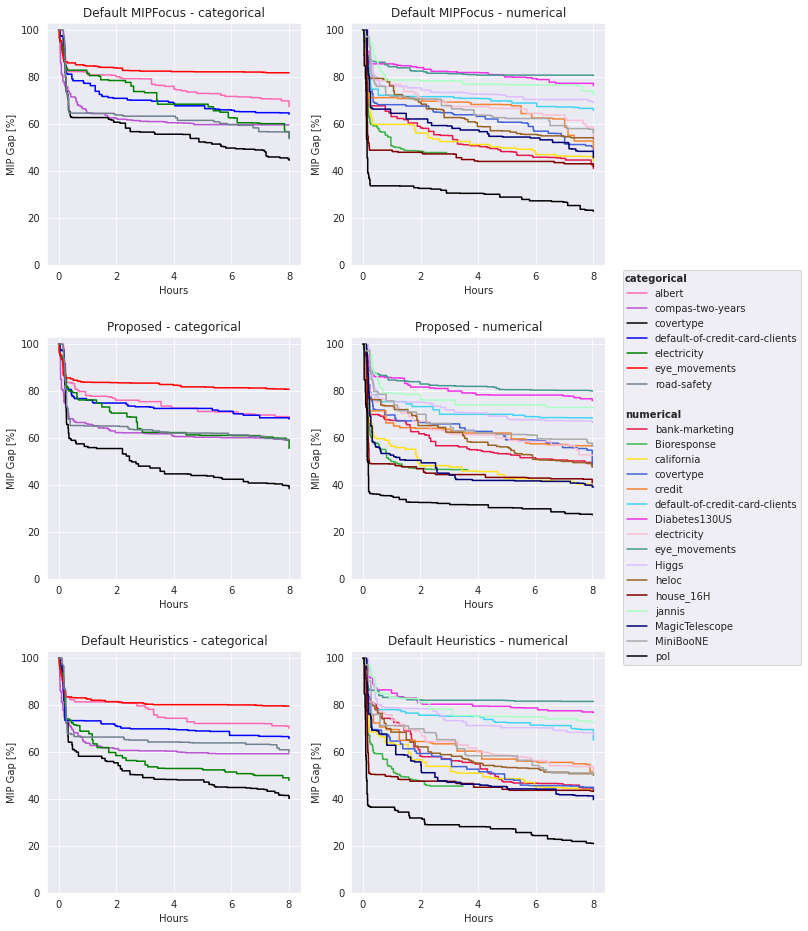

In [25]:
i = 0
fig, ax = plt.subplots(3, 2, figsize=(10,16))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

for stats, name in [(stats0f, "Default MIPFocus"), (stats8h, "Proposed"), (stats05h, "Default Heuristics")]:
    leg = {}
    colormaps = [['hotpink', 'mediumorchid', 'black', 'blue', 'green', 'red', 'slategrey'],
                 ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#42d4f4', '#f032e6', '#fabed4', '#469990', 
         '#dcbeff', '#9A6324', '#800000', '#aaffc3', '#000075', '#a9a9a9', '#000000']]
    for colors, dtype in zip(colormaps, DATASETS_INFO):
        leg[dtype] = [[Patch(visible=False), dtype]]
        
        for c, dataset in zip(colors, DATASETS_INFO[dtype]):
            mean_gap = np.zeros((9*3600,)) # make it larger and crop at the end
            max_time = 0
            for j in range(10):
                vals = stats[f"{j}_{dtype[0]}_{dataset}"]
                # print(vals)
                gap = np.full((9*3600,), 100)
                max_time = max(max_time, max(vals["Time"]))
                for t, g in zip(vals["Time"], vals["Gap"]):
                    gap[t:] = g
                mean_gap += gap

            mean_gap = mean_gap[:max_time+1] / 10

            # label = dataset if len(dataset) < 15 or i == 0 else dataset[:15]+"..."
            label = dataset 
            l, = ax[i//2, i%2].step(np.arange(mean_gap.shape[0])/3600, mean_gap, where="post", label=label, c=c)
            leg[dtype].append([l, label])
            # leg[dtype].append(l)
            # ax[i].step(np.array([0] + list(reversed(vals["Time"])) + [8*3600])/3600, [100] + list(reversed(vals["Gap"])) + vals["Gap"][:1], where="post")
            ax[i//2, i%2].set_title(f"{name} - {dtype}")
            ax[i//2, i%2].set_xlabel("Hours")
            ax[i//2, i%2].set_ylabel("MIP Gap [%]")
            ax[i//2, i%2].set_ylim(0,103)
            # ax[i//2, i%2].set_xlim(0,8)
            
        i += 1
leg = ax[-2, -1].legend(
    *list(zip(*(leg["categorical"]+[[Patch(visible=False), ""]]+leg["numerical"]))),
    bbox_to_anchor=(1.05, 1.3)
)        
style_legend_titles_by_setting_position(leg, bold=True)

plt.savefig("master_plots/MIPGaps_time_detail.pdf", bbox_inches='tight')

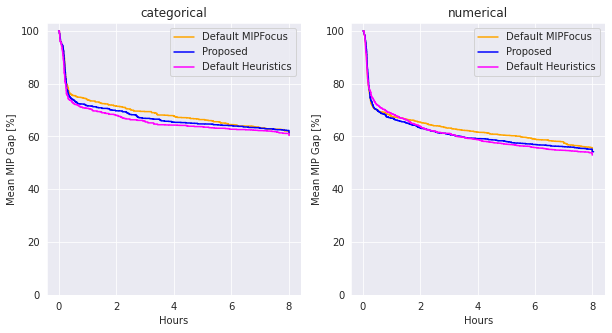

In [26]:
# for stats in [stats8h, stats1h, stats0f]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for stats, name, color in [(stats0f, "Default MIPFocus", "orange"), (stats8h, "Proposed", "b"), (stats05h, "Default Heuristics", "magenta")]:
    i = 0
    for dtype in DATASETS_INFO:
        mean_gap = np.zeros((9*3600,)) # make it larger and crop at the end
        max_time = 0
        for dataset in DATASETS_INFO[dtype]:
            for j in range(10):
                vals = stats[f"{j}_{dtype[0]}_{dataset}"]
                # print(vals)
                gap = np.full((9*3600,), 100)
                max_time = max(max_time, max(vals["Time"]))
                for t, g in zip(vals["Time"], vals["Gap"]):
                    gap[t:] = g
                mean_gap += gap

        mean_gap = mean_gap[:max_time+1] / (10*len(DATASETS_INFO[dtype]))

        label = name
        ax[i].step(np.arange(mean_gap.shape[0])/3600, mean_gap, where="post", color=color, label=label)
        # ax[i].step(np.array([0] + list(reversed(vals["Time"])) + [8*3600])/3600, [100] + list(reversed(vals["Gap"])) + vals["Gap"][:1], where="post")
        ax[i].set_title(dtype)
        ax[i].set_xlabel("Hours")
        ax[i].set_ylabel("Mean MIP Gap [%]")
        ax[i].set_ylim(0,103)
        # ax[i].set_xscale('log')
        # ax[i].legend(ncol=2*i+1)
        ax[i].legend()
        i += 1
    
# plt.show()
plt.savefig("master_plots/MIPGaps_time.pdf", bbox_inches='tight')

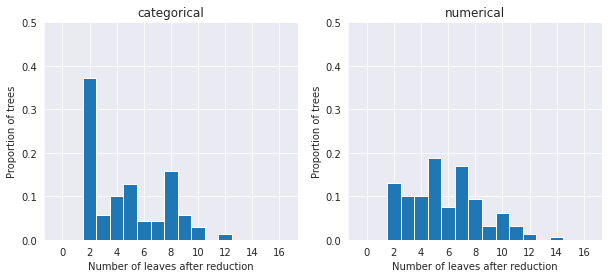

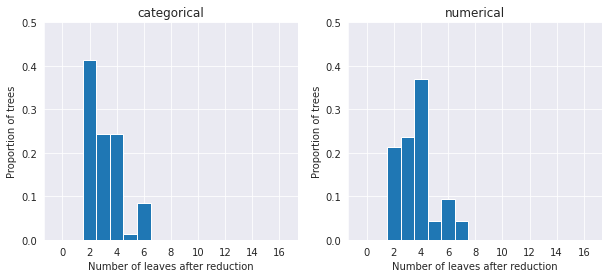

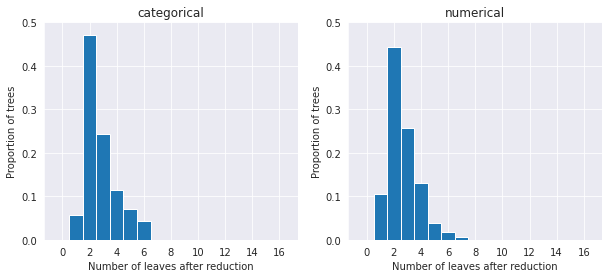

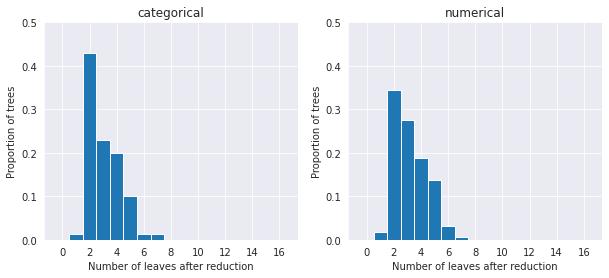

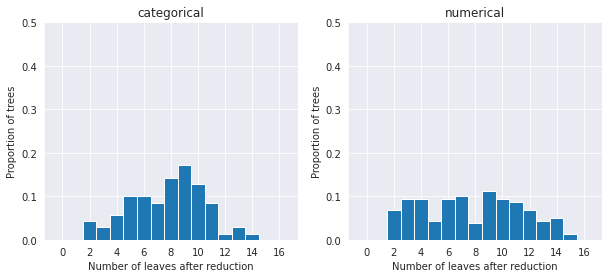

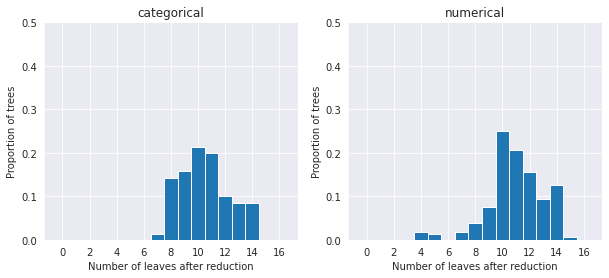

In [27]:
for name in ["warm_best", "warm_d3", "direct", "gradual", "OCT", "OCT_warm"]:
    i = 0
    var = "RemovedLeaves"
    if "grad" in name:
        var += "4"
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    for dtype in DATASETS_INFO:
        val = 16 - jobs[name][(jobs[name]["DataType"] == dtype)][var]
        if "_d3" in name:
            val = 8 - jobs[name][(jobs[name]["DataType"] == dtype)][var]
        axes[i].hist(val, bins=np.arange(18)-0.5, density=True)
        axes[i].set_title(dtype)
        axes[i].set_xlabel("Number of leaves after reduction")
        # if i == 0:
        axes[i].set_ylabel("Proportion of trees")
        axes[i].set_ylim((0,0.5))
        axes[i].set_xticks(np.arange(0, 17, 2))
        i += 1

    # plt.suptitle("Amount of reduced leaves")
    plt.savefig(f"master_plots/reduction_{name}.pdf", bbox_inches='tight')

Rounding to more than 4 decimal numbers may lead to inaccuracies in the model.
Checkout https://www.gurobi.com/documentation/10.0/refman/feasibilitytol.html for a potential way to help this
Rounding to more than 4 decimal numbers may lead to inaccuracies in the model.
Checkout https://www.gurobi.com/documentation/10.0/refman/feasibilitytol.html for a potential way to help this
Rounding to more than 4 decimal numbers may lead to inaccuracies in the model.
Checkout https://www.gurobi.com/documentation/10.0/refman/feasibilitytol.html for a potential way to help this
Rounding to more than 4 decimal numbers may lead to inaccuracies in the model.
Checkout https://www.gurobi.com/documentation/10.0/refman/feasibilitytol.html for a potential way to help this
Rounding to more than 4 decimal numbers may lead to inaccuracies in the model.
Checkout https://www.gurobi.com/documentation/10.0/refman/feasibilitytol.html for a potential way to help this
Rounding to more than 4 decimal numbers may lead t

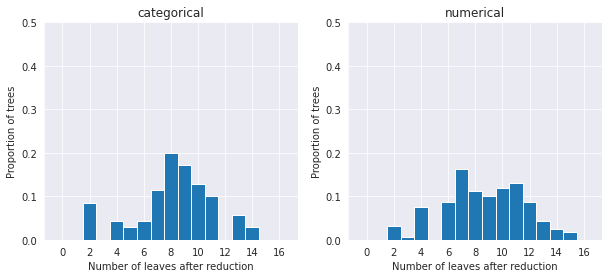

In [28]:
import pickle
from fct.DataHandler import DataHandler
from fct.TreeGenerator import TreeGenerator
from sklearn import tree as skltree

with open(TREE_PATHS["depth4"], "rb") as f:
    data = pickle.load(f)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
     
j = 0
for dtype in DATASETS_INFO:
    vals = []
    for dataset in DATASETS_INFO[dtype]:
        did = f"{dtype[0]}_{dataset}"
        dataset_path = DATASETS_INFO[dtype][dataset]["path"]
        for i, params in enumerate(data[did]["best_params"]):
            data_h = DataHandler(dataset_path, round_limit=40)
            X_train, y_train = data_h.get_training_data(split_seed=i, test_size=0.2, limit=10000)

            dt_sklearn = skltree.DecisionTreeClassifier(**params)
            dt_sklearn.fit(X_train, y_train)
             
            gen = TreeGenerator(data_h)
            tree = gen.make_from_sklearn(dt_sklearn.tree_, 0, data_h.normalize(data_h.used_data[0]))
            d = 2**tree.depth
            tree.reduce_tree(data_h)

            X, y = data_h.used_data
            X_reduced = data_h.unnormalize(data_h.normalize(X))
            vals.append(len(tree.get_leafs_with_data(X_reduced)))
                
    axes[j].hist(vals, bins=np.arange(18)-0.5, density=True, label=dataset)
    axes[j].set_title(dtype)
    axes[j].set_xlabel("Number of leaves after reduction")
    # if j == 0:
    axes[j].set_ylabel("Proportion of trees")
    axes[j].set_ylim((0,0.5))
    axes[j].set_xticks(np.arange(0, 17, 2))
    j += 1
plt.savefig(f"master_plots/reduction_CART.pdf", bbox_inches='tight')

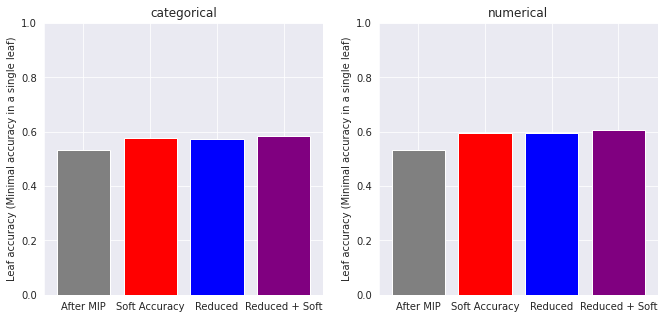

In [29]:
xgbvals = get_XGB_est_values()


fig, axes = plt.subplots(1, 2, figsize=(11,5))
values = {}

modelname = "warm_best"
values["After MIP"] = {
    "base": get_values_categ(jobs, modelname, reduced=False),
    "extended": get_values_categ(jobs, modelname, extended=True)
}
values["Soft Accuracy"] = {
    "base": get_values_categ(jobs, modelname, reduced=False, soft=20),
    "extended": get_values_categ(jobs, modelname, extended=True, soft=20)
}
values["Reduced"] = {
    "base": get_values_categ(jobs, modelname, reduced=True),
    "extended": get_values_categ(jobs, modelname, extended=True, soft=20)
}
values["Reduced + Soft"] = {
    "base": get_values_categ(jobs, modelname, reduced=True, soft=20),
    "extended": get_values_categ(jobs, modelname, extended=True, soft=20)
}

# values["CART"] = {
#     "base": get_tree_results_categ(TREE_PATHS["depth4"]),
#     "extended": get_tree_results_categ(TREE_PATHS["depth4"], extended=False)
# }
i = 0

for dtype in DATASETS_INFO:
    colors = ["grey", "red", "b", "purple"]
    toplot = []
    for c, n in zip(colors, values):
        vals = values[n]["base"][dtype]
        toplot.append(vals["TestLeafAcc"].mean())
    axes[i].bar(values.keys(), toplot, color=colors)
    axes[i].set_ylim([0,1])

#         vals = values[n]["extended"][dtype]
#         plot_hybrid(axes[i%2], vals["TestAcc"], vals["TestLeafAcc"], c)

    # show_xgb(axes[i%2], xgbvals[dtype]["TestAcc"].mean())
    
    set_labels(axes[i%2], dtype, xlabel="")
    i += 1
        
# set_legend(axes[1], values.keys(), colors, anchor=(1.52, 0.5))
# legend_elements = [Patch(facecolor=c, edgecolor=(1,1,1,0), label=l) for c, l in zip(colors, values.keys())]
# axes[1].legend(handles=legend_elements, bbox_to_anchor=(1.4, 0.6))


# plt.show()
plt.savefig(f"master_plots/soft_effect.pdf", bbox_inches='tight')


In [30]:
xgbvals = get_XGB_est_values()


values = {}
values["CART"] = {
    "base": get_tree_results(TREE_PATHS["depth4"]),
    "extended": get_tree_results(TREE_PATHS["depth4"], extended=True)
}
for name, modelname in [
        ("Proposed", "warm_best"), 
        # ("OCT", "OCT"), 
        # ("OCT warmstarted", "OCT_warm"), 
        # ("Gradual", "gradual"), 
        # ("Direct", "direct"), 
        # ("Default Heuristcs", "warm_05heur"), 
        # ("Default MIPFocus", "warm_0focus"), 
        # ("1Hour", "warm_1hour"),
        # ("NoLim", "warm_nolim"),
        # ("Depth", "warm_d5"),
    ]:
    values[name] = {
        "base": get_values(jobs, modelname, reduced=True),
        "extended": get_values(jobs, modelname, extended=True)
    }


tables = {}
tot_tables = {
    "TestAcc": pd.DataFrame([]),
    "TestLeafAcc": pd.DataFrame([]),
}
for dtype in DATASETS_INFO:
    tables[dtype] = {}
    accs = []
    laccs = []
    for dataset in DATASETS_INFO[dtype]:
        accs.append([])
        laccs.append([])
        for n in values:
            accs[-1].append(values[n]["extended"][dtype][dataset]["TestAcc"].mean())
            laccs[-1].append(values[n]["extended"][dtype][dataset]["TestLeafAcc"].mean())
        accs[-1].append(DATASETS_INFO[dtype][dataset]["pure_xgb_benchmark_acc"])
    
    tables[dtype]["TestAcc"] = pd.concat((pd.DataFrame(accs), pd.DataFrame([make_ranking(accs)])))
    tables[dtype]["TestLeafAcc"] = pd.concat((pd.DataFrame(laccs), pd.DataFrame([make_ranking(laccs)])))
    tot_tables["TestAcc"] = pd.concat((tot_tables["TestAcc"], pd.DataFrame(accs)))
    tot_tables["TestLeafAcc"] = pd.concat((tot_tables["TestLeafAcc"], pd.DataFrame(laccs)))

    
tot_tables["TestAcc"] = pd.concat((tot_tables["TestAcc"], pd.DataFrame([make_ranking(tot_tables["TestAcc"].to_numpy())])))
tot_tables["TestLeafAcc"] = pd.concat((tot_tables["TestLeafAcc"], pd.DataFrame([make_ranking(tot_tables["TestLeafAcc"].to_numpy())])))
    

In [31]:
for dtype in DATASETS_INFO:
    tables[dtype]["TestLeafAcc"].set_index(pd.Index(list(DATASETS_INFO[dtype]) + ["Mean rank"]), inplace=True)
    tables[dtype]["TestLeafAcc"].rename(columns={i: v for i,v in enumerate(values.keys())}, inplace=True)

    tables[dtype]["TestAcc"].set_index(pd.Index(list(DATASETS_INFO[dtype]) + ["Mean rank"]), inplace=True)
    tables[dtype]["TestAcc"].rename(columns={i: v for i,v in enumerate(values.keys())}, inplace=True)
    tables[dtype]["TestAcc"].rename(columns={len(values): "XGBoost"}, inplace=True)
    # tables[dtype]["TestAcc"].set_index(list(DATASETS_INFO[dtype]) + ["Mean rank"])

    print(pd.concat([tables[dtype]["TestLeafAcc"], tables[dtype]["TestAcc"]], axis=1).to_latex(
        float_format="{:.4f}".format,
    )) 
# tables[dtype][method]

\begin{tabular}{lrrrrr}
\toprule
{} &   CART &  Proposed &   CART &  Proposed &  XGBoost \\
\midrule
albert                         & 0.4674 &    0.5706 & 0.6466 &    0.6510 &   0.6559 \\
compas-two-years               & 0.4631 &    0.5711 & 0.6754 &    0.6772 &   0.6807 \\
covertype                      & 0.5166 &    0.7071 & 0.8409 &    0.8567 &   0.8658 \\
default-of-credit-card-clients & 0.3346 &    0.5246 & 0.7132 &    0.7117 &   0.7184 \\
electricity                    & 0.5404 &    0.6250 & 0.8808 &    0.8781 &   0.8861 \\
eye\_movements                  & 0.4356 &    0.4109 & 0.6267 &    0.6449 &   0.6677 \\
road-safety                    & 0.5228 &    0.6158 & 0.7570 &    0.7579 &   0.7689 \\
Mean rank                      & 1.8571 &    1.1429 & 2.7143 &    2.2857 &   1.0000 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrr}
\toprule
{} &   CART &  Proposed &   CART &  Proposed &  XGBoost \\
\midrule
bank-marketing                 & 0.4083 &    0.5837 & 0.8011 &    0.8003 &

/tmp/ipykernel_1459910/1393449345.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([tables[dtype]["TestLeafAcc"], tables[dtype]["TestAcc"]], axis=1).to_latex(
/tmp/ipykernel_1459910/1393449345.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([tables[dtype]["TestLeafAcc"], tables[dtype]["TestAcc"]], axis=1).to_latex(


In [32]:
for dtype in DATASETS_INFO:
    vals = pd.DataFrame(DATASETS_INFO[dtype]).T
    vals.drop(columns=["path", "pure_xgb_benchmark_acc"], inplace=True)
    vals.rename(columns={"n_points": "# of samples", "n_features": "# of features", "n_classes": "# of classes"}, inplace=True)
    
    print(vals.to_latex()) 

\begin{tabular}{llll}
\toprule
{} & \# of samples & \# of features & \# of classes \\
\midrule
albert                         &        58252 &            31 &            2 \\
compas-two-years               &         4966 &            11 &            2 \\
covertype                      &       423680 &            54 &            2 \\
default-of-credit-card-clients &        13272 &            21 &            2 \\
electricity                    &        38474 &             8 &            2 \\
eye\_movements                  &         7608 &            23 &            2 \\
road-safety                    &       111762 &            32 &            2 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} & \# of samples & \# of features & \# of classes \\
\midrule
bank-marketing                 &        10578 &             7 &            2 \\
Bioresponse                    &         3434 &           419 &            2 \\
california                     &        20634 &             8 

/tmp/ipykernel_1459910/3789076853.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(vals.to_latex())
/tmp/ipykernel_1459910/3789076853.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(vals.to_latex())


51.10646035671234
29.21786677837372
77.26682848930359
23.89479112625122


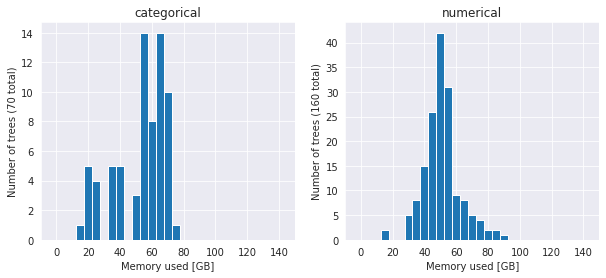

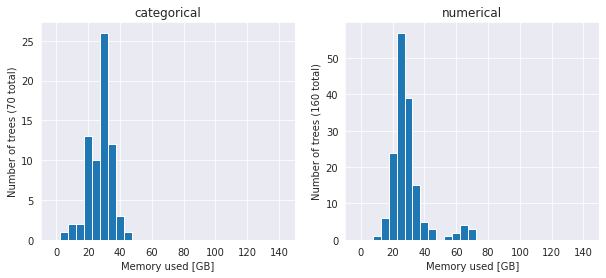

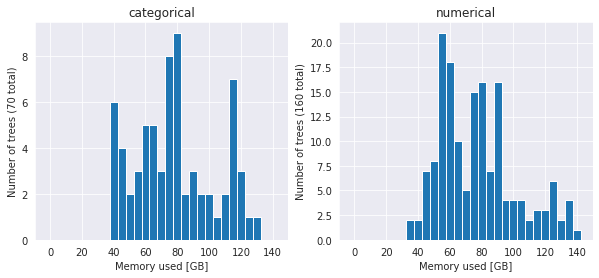

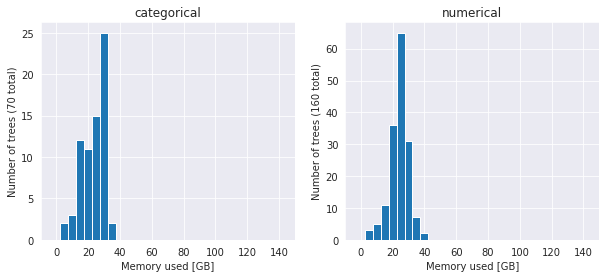

In [33]:
# name = "warm_best"
for name in ["warm_best", "warm_1hour", "warm_d5", "warm_d3"]:
    i = 0
    var = "MemRSS"
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    v = []
    for dtype in DATASETS_INFO:
        val = jobs[name][(jobs[name]["DataType"] == dtype)][var]
        # if np.any(val > 95):
        axes[i].hist(val, bins=(np.arange(150/5)-0.5)*5, density=False, label=dataset)
        v += list(val)
        # else: 
        #     print(val.mean())
        #     axes[i].hist(val, bins=(np.arange(100/5)-0.5)*5, density=False, label=dataset)
        axes[i].set_title(dtype)
        axes[i].set_xlabel("Memory used [GB]")
        axes[i].set_ylabel(f"Number of trees ({len(val)} total)")
        i += 1
    print(sum(val)/len(val))

    plt.savefig(f"master_plots/memory_hist_{name}.pdf", bbox_inches='tight')

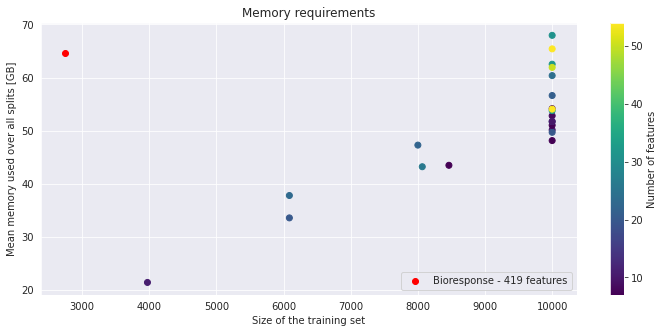

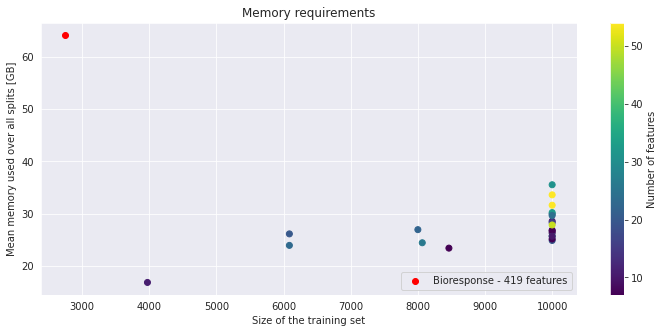

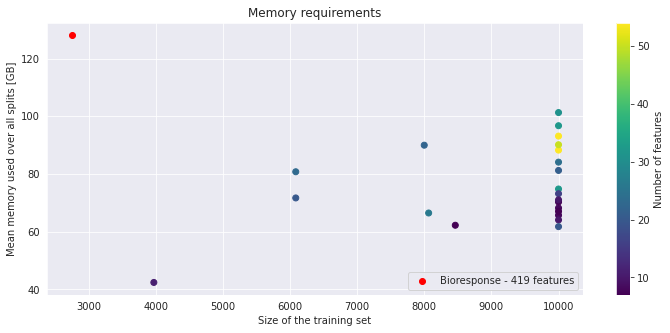

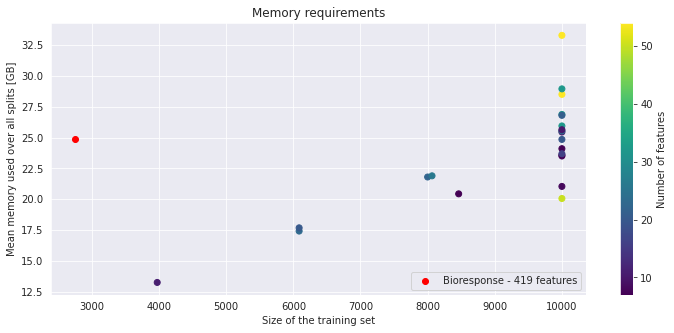

In [34]:

for name in ["warm_best", "warm_1hour", "warm_d5", "warm_d3"]:
    var = "MemRSS"
    fig, axes = plt.subplots(1, 1, figsize=(12,5))
    vals = []
    sizes = []
    feats = []
    for dtype in DATASETS_INFO:
        for dataset in DATASETS_INFO[dtype]:
            train_size = DATASETS_INFO[dtype][dataset]["n_points"] * 0.8
            if train_size > 10000: 
                train_size = 10000
            val = jobs[name][(jobs[name]["DataType"] == dtype) & (jobs[name]["DatasetName"] == dataset)][var].mean()
            if DATASETS_INFO[dtype][dataset]["n_features"] > 100:
                axes.scatter([train_size],[val],color="r",label=f"{dataset} - {DATASETS_INFO[dtype][dataset]['n_features']} features")
                continue
            vals.append(val)
            sizes.append(train_size)
            feats.append(DATASETS_INFO[dtype][dataset]["n_features"])
    im = axes.scatter(sizes, vals, c=feats, cmap=plt.cm.get_cmap('viridis'))
    axes.set_title("Memory requirements")
    axes.set_xlabel(f"Size of the training set")
    axes.set_ylabel("Mean memory used over all splits [GB]")
    axes.legend(loc="lower right")

    cbar = fig.colorbar(im)
    cbar.ax.set_ylabel("Number of features")

    i += 1


    plt.savefig(f"master_plots/memory_scatter_{name}.pdf", bbox_inches='tight')

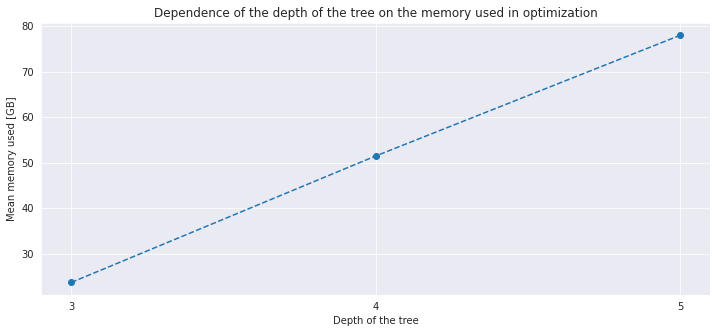

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(12,5))
i = 3
vals = []
var = "MemRSS"
for name in ["warm_d3", "warm_best", "warm_d5"]:
    vals.append(jobs[name][var].mean())
    i += 1

axes.plot(range(3,6), vals, "o--")
axes.set_title("Dependence of the depth of the tree on the memory used in optimization")
axes.set_ylabel("Mean memory used [GB]")
axes.set_xlabel("Depth of the tree")
axes.set_xticks([3,4,5])

plt.savefig(f"master_plots/depth_memory.pdf", bbox_inches='tight')